In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DTU/Deep Learning/Project
# different loss function

/content/drive/MyDrive/Colab Notebooks/DTU/Deep Learning/Project


In [ ]:
!cd ..
!mkdir data
!cd data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2021-11-01 14:59:44--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  36.3MB/s    in 4.6s    

2021-11-01 14:59:49 (35.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [70]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
import random

import torch
cuda = torch.cuda.is_available()

import torchvision
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import transforms, ToTensor
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, leaky
import torch.optim as optim

from data import load_cifar_10_data
from dataset import Cifar10AutoEncoderDataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# try:
#     from plotting import plot_autoencoder_stats
# except Exception as ex:
#     print(f"If using Colab, you may need to upload `plotting.py`. \
#           \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
#           \n---------------------------------------------")
#     print(ex)

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [87]:
train_imgs, test_imgs = load_cifar_10_data("cifar-10-batches-py")

# Decrease size of the datasets
idx_train = np.random.permutation(np.arange(0,len(train_imgs)))[:10000]
idx_test = np.random.permutation(np.arange(0,len(test_imgs)))[:2000]
train_imgs = train_imgs[idx_train]
test_imgs = test_imgs[idx_test]

batch_size = 16

preprocess_transform = A.Compose([
    # transforms.Resize((32, 32)),
    A.Normalize((0.5, ), (0.5, )),
    ToTensorV2()]
)

transform = A.Compose([
    A.GaussNoise(var_limit=(30, 70), mean=0, p=1),
    # A.MultiplicativeNoise()
    # A.Blur(p=1)
    A.CoarseDropout(max_height=2, max_width=2, min_holes=2, max_holes=5)
])

train_set = Cifar10AutoEncoderDataset(train_imgs, preprocess_transform, transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = Cifar10AutoEncoderDataset(test_imgs, preprocess_transform, transform)#
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [88]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.5, 0.5, 0.5])
  STD = 255 * np.array([0.5, 0.5, 0.5])
  image = ((image * STD)+ MEAN).astype(int)
  return image

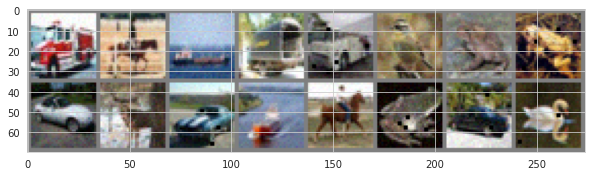

In [89]:
# Load a batch of images into memory
images, labels = next(iter(train_loader))

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)

# show images
plt.figure(figsize = (10, 5))
imshow(torchvision.utils.make_grid(images))

In [90]:
import torch.nn as nn
from torch.autograd import Variable

channels, width, height = images.shape[1:4]

# define size variables
num_features = width*height*channels

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,hidden_units3,latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=50)

net = net.to(device)

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=3072, bias=True)
  )
)


In [91]:
class AutoEncoderBatchNorm(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,hidden_units3,latent_features=2):
        super(AutoEncoderBatchNorm, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.BatchNorm1d(hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.BatchNorm1d(hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.BatchNorm1d(hidden_units3),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.BatchNorm1d(hidden_units3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.BatchNorm1d(hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.BatchNorm1d(hidden_units1),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

In [99]:
class AutoEncoderLeakyReLU(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,hidden_units3,latent_features=2):
        super(AutoEncoderLeakyReLU, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.LeakyReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units3, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units3),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.LeakyReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

In [105]:
class AutoEncoderLeakyReLUShallow(nn.Module):
    def __init__(self, hidden_units1, hidden_units2,latent_features=2):
        super(AutoEncoderLeakyReLUShallow, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.LeakyReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units2, out_features=latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units1),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units1, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        z = self.encoder(x)
        
        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.tanh(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }

In [106]:
net = AutoEncoderLeakyReLUShallow(hidden_units1=1024, hidden_units2=512, latent_features=50).to(device)
x, y = next(iter(train_loader))
x = torch.reshape(x, (x.shape[0], -1))
print(f"x.shape = {x.shape}")

outputs = net(x.to(device))
print(f"x_hat.shape = {outputs['x_hat'].shape}")

x.shape = torch.Size([16, 3072])
x_hat.shape = torch.Size([16, 3072])


Training loop:

In [96]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 50
def train(net, optimizer, loss_fun, num_epochs = 50):
  train_loss = []
  valid_loss = []

  for epoch in range(num_epochs):
      batch_loss = []
      avg_loss = 0
      net.train()
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:

          x = torch.reshape(x, (x.shape[0], -1))
          
          x = x.to(device)
          
          outputs = net(x)
          x_hat = outputs['x_hat']

          # note, target is the original tensor, as we're working with auto-encoders
          loss = loss_function(x_hat, x)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          batch_loss.append(loss.item())

          avg_loss += loss.item() / len(x)

      train_loss.append(np.mean(batch_loss))

      # Evaluate, do not propagate gradients
      with torch.no_grad():
          net.eval()
          
          # Just load a single batch from the test loader
          x_val, y_val = next(iter(test_loader))
          
          x_val = torch.reshape(x_val, (x_val.shape[0], -1))
          
          x_val = x_val.to(device)
          
          outputs = net(x_val)

          # We save the latent variable and reconstruction for later use
          # we will need them on the CPU to plot
          x_hat = outputs['x_hat']
          z = outputs['z'].cpu().numpy() # latent features

          loss = loss_function(x_hat, x_val)

          valid_loss.append(loss.item())

          clear_output(wait=True)
          x_val = x_val.cpu().reshape((batch_size, channels, height, width))
          x_hat = x_hat.cpu().reshape((batch_size, channels, height, width))
          k = 0
          plt.figure(figsize = (15, 7))
          for m in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(denormalize(x_val[m]))
            # plt.imshow(x_val[m][0].numpy(), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(denormalize(x_hat[m]))
            # plt.imshow(x_hat[m], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(denormalize(y_val[m]))
            # plt.imshow(y_val[m][0], cmap='gray')
            plt.title('Target')
            plt.axis('off')
            
            k+=1
          plt.suptitle('%d / %d - loss: %f' % (epoch+1, num_epochs, avg_loss))
          plt.show()
      
      # if epoch == 0:
      #     continue
      # if epoch % 10 == 0:
      #   print(epoch, " Train loss: ", train_loss[-1], " Valid loss: ", valid_loss[-1])

      fig = plt.figure(figsize=(12,4))
      plt.plot(train_loss, 'b', label = "Tran loss")
      plt.plot(valid_loss, 'orange', label = "Validation loss")
      plt.legend()
      plt.show()
      clear_output(wait=True)

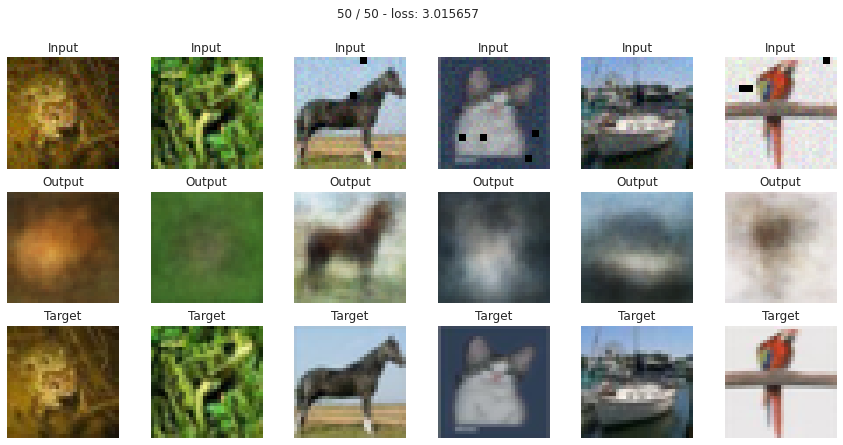

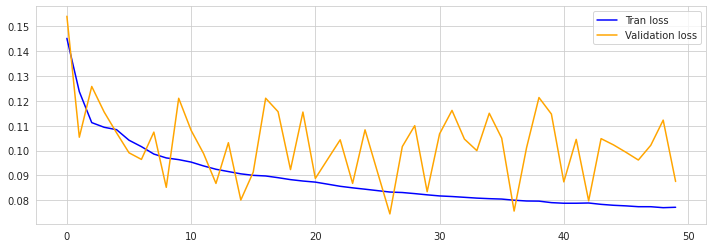

In [93]:
net = AutoEncoder(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=100)
net = net.to(device)
# for L2 regularization, then add weight_decay to SGD
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, LR_STEP_SIZE, gamma=0.1, last_epoch=-1, verbose=False)
# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

train(net, optimizer, loss_function, 50)

# it is really bad for images with no constracting colours. 
# When the cours are contracting, it can at least reconstruct a very blury shape of the main object in the image

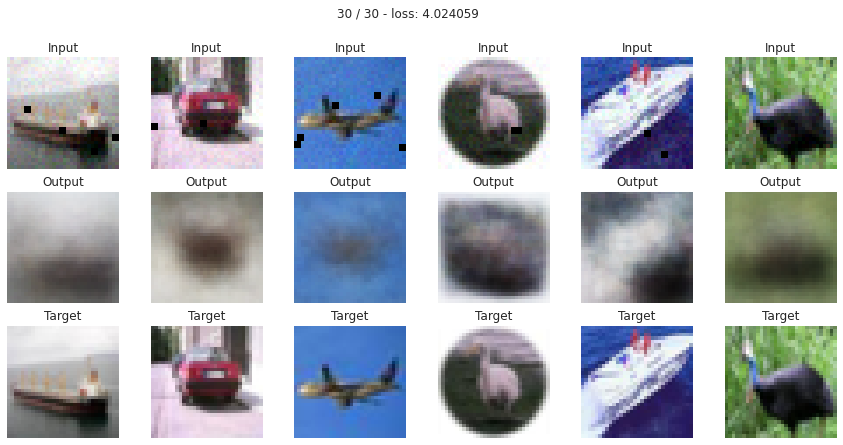

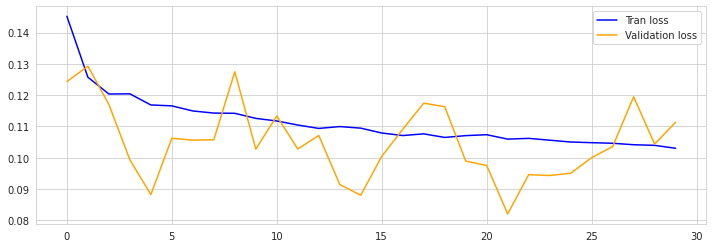

In [97]:
net = AutoEncoderBatchNorm(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=100)
net = net.to(device)
# for L2 regularization, then add weight_decay to SGD
optimizer = optim.Adam(net.parameters(), lr=0.001)
# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

train(net, optimizer, loss_function, 30)

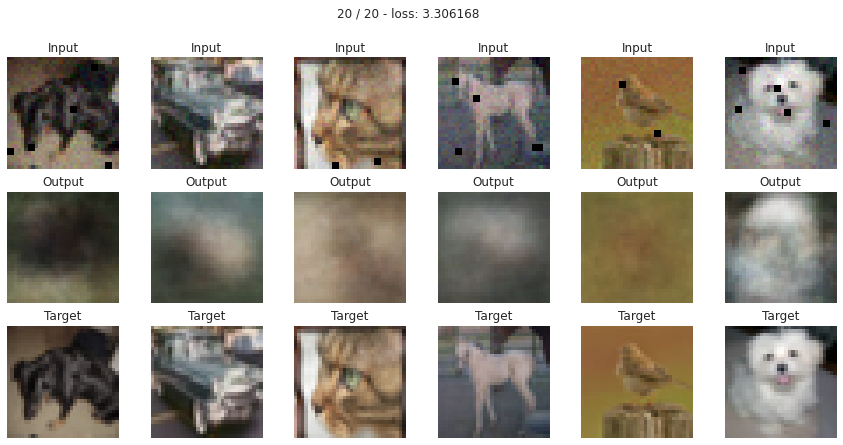

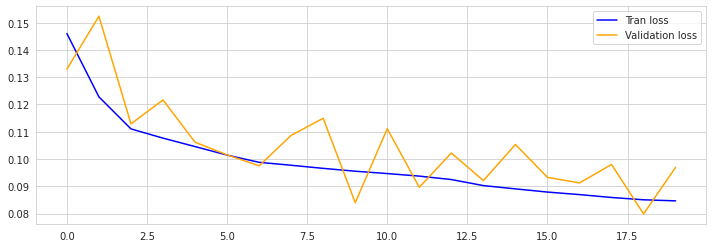

In [100]:
net = AutoEncoderLeakyReLU(hidden_units1=1024, hidden_units2=512, hidden_units3=128, latent_features=100)
net = net.to(device)
# for L2 regularization, then add weight_decay to SGD
optimizer = optim.Adam(net.parameters(), lr=0.001)
# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

train(net, optimizer, loss_function, 20)

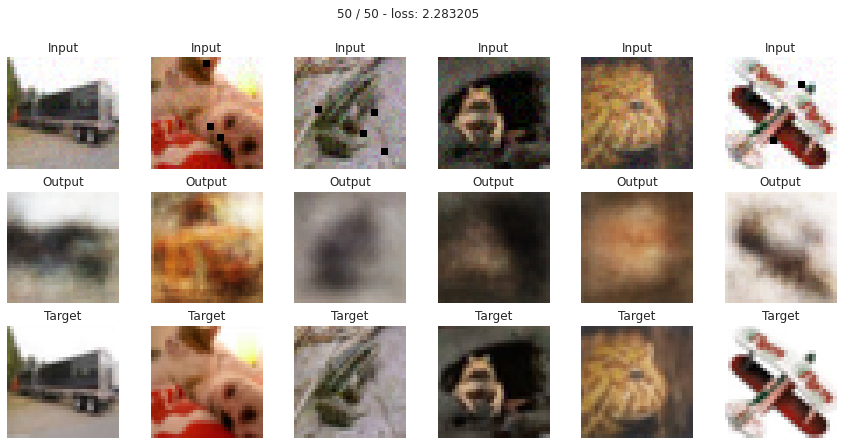

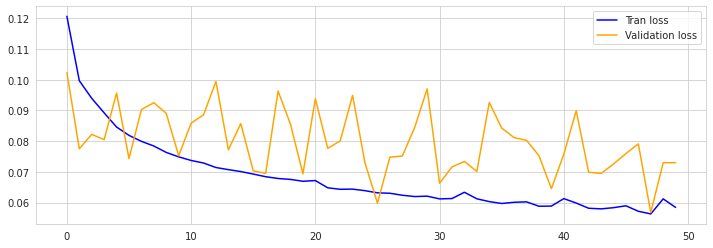

In [108]:
net = AutoEncoderLeakyReLUShallow(hidden_units1=1024, hidden_units2=512, latent_features=100)
net = net.to(device)
# for L2 regularization, then add weight_decay to SGD
optimizer = optim.Adam(net.parameters(), lr=0.001)
# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

train(net, optimizer, loss_function, num_epochs=50)